In [1]:
import numpyro
numpyro.enable_x64()
# numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

import jax
from jax import numpy as jnp
from jax import random, vmap
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, Predictive, SA
from numpyro.contrib.funsor import config_enumerate

from jax.scipy.special import digamma, polygamma, logit, expit, erf, gammaln

import numpy as np
from numpy.random import default_rng
import pandas as pd
import siuba as s

from numpy import exp, log

import scipy

from plotnine import *
# import seaborn as sns

# Testing on some rounded data

In [2]:
from jax.random import PRNGKey

X_raw = dist.Beta(.75*10, (1-.75)*10).sample(PRNGKey(10), (100,))
x_round = round(X_raw*10)
x_round

DeviceArray([ 7,  7,  8,  8, 10,  7,  6,  8,  7,  9,  8,  7,  8,  9,  9,
              7,  8,  7,  5,  6,  9,  6,  8,  9,  9,  8,  9,  9,  8,  8,
              8,  5,  8,  3,  6,  7,  9,  7,  9,  5,  8,  9,  8,  6,  5,
              7,  6,  6, 10,  7,  9,  9,  8,  8,  6,  9,  5,  8,  8,  7,
              5,  5,  9,  9,  8,  8,  9,  8,  6,  7,  7,  9,  8,  7,  5,
              6,  9,  9,  9,  6,  7,  8,  9,  7,  5,  7,  8,  8,  8,  8,
              8,  9,  8,  8,  8,  7,  9,  8,  7,  8], dtype=int64)

In [3]:
def mymodel(x=None):
    mu = numpyro.sample("mu", dist.Beta(1,1)) # noise parameter
    k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter
    
    with numpyro.plate("data", x.shape[0]):
        xhat = numpyro.sample("xhat", dist.Beta(mu*k, (1-mu)*k), obs=x)

In [87]:
kernel = NUTS(mymodel, target_accept_prob=.80)

mcmc = MCMC(kernel, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc.run(random.PRNGKey(0), X_raw)

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1075.68it/s, 3 steps of size 8.10e-01. acc. prob=0.92]


In [88]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      8.81      1.19      8.77      6.87     10.73   1224.80      1.00
        mu      0.75      0.01      0.75      0.72      0.77   1217.59      1.00

Number of divergences: 0


In [103]:
import tensorflow_probability.substrates.jax as tfp

def f(mu, k):
    a = mu*k
    b = (1.-mu)*k
    
    responses = jnp.linspace(0,10, num=11)
    lower = jnp.clip((responses/10.) - .05, 1e-3, 1-1e-3)
    upper = jnp.clip((responses/10.) + .05, 1e-3, 1-1e-3)
    
    prob_resps = tfp.math.betainc(a, b, upper) - tfp.math.betainc(a, b, lower)
    prob_resps = prob_resps / jnp.sum(prob_resps)
    
    return(prob_resps)


def mymodel_round(x=None):
    mu = numpyro.sample("mu", dist.Beta(1,1)) # noise parameter
    k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter

    resp_probs = f(mu,k)
    resp_probs = resp_probs/jnp.sum(resp_probs)
    
    with numpyro.plate("data", x.shape[0]):

        xhat = numpyro.sample("xhat", dist.Categorical(probs=resp_probs), obs=x)


In [104]:
from numpyro.infer import init_to_median, init_to_value

kernel = NUTS(mymodel_round, target_accept_prob=.80, init_strategy = init_to_value(values={"mu":.33, "k":5}))

mcmc = MCMC(kernel, 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=1)

mcmc.run(random.PRNGKey(0), x_round)

sample: 100%|██████████| 2000/2000 [00:08<00:00, 247.03it/s, 3 steps of size 7.96e-01. acc. prob=0.93] 


In [261]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      9.69      1.43      9.69      7.50     12.03    785.03      1.00
        mu      0.75      0.01      0.75      0.73      0.77    776.91      1.00

Number of divergences: 0


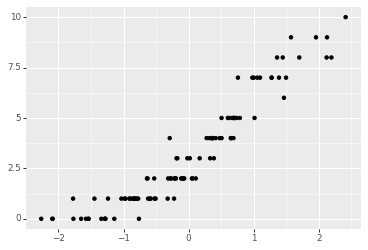

<ggplot: (8741829331514)>

In [5]:
x_norm = dist.Normal(0.,1.).sample(PRNGKey(1), (100,))
y = expit(-1 + 1.5*x_norm)
y = dist.Beta(y*50., (1-y)*50.).sample(PRNGKey(1))

y_round_10 = round(y*10)
y_round_5 = round(y*20)
y_round_1 = round(y*100)


# x_binary = dist.Bernoulli(.5).sample(PRNGKey(1), (100,))
# y = .25 + x_binary*.50
# y = dist.Beta(y*50., (1-y)*50.).sample(PRNGKey(0))

# y_round_bin10 = round(y*10)
# y_round

ggplot(aes(x=x_norm, y=y_round_10)) + geom_point()

In [6]:
# def f2(mu, k):
#     a = mu*k
#     b = (1.-mu)*k
    
#     rnd_unit_scaled = 1/10.
    
#     responses = jnp.linspace(0, 10, num=11)
#     cuts = responses/10.
    
#     ## avoid calculating betainc near 0 and 1 seems to speed up sampling
#     upper_probs = jnp.pad(tfp.math.betainc(a, b, cuts[0:10]+.05), (0,1), constant_values=(0.,1.))
#     lower_probs = jnp.pad(tfp.math.betainc(a, b, cuts[1:11]-.05), (1,0), constant_values=(0.,1.))

#     prob_resps = upper_probs - lower_probs
#     prob_resps = (prob_resps + 1e-16) / jnp.sum(prob_resps)
    
#     return(prob_resps)


responses_10 = jnp.linspace(0, 10, num=11)
responses_5 = jnp.linspace(0, 20, num=21)
responses_1 = jnp.linspace(0, 101, num=101)

def f2(mu, k, responses):
    # responses = jnp.linspace(0, 10, num=11)
    
    a = mu*k
    b = (1.-mu)*k
    
    n_resps = (responses.shape[0]-1)
    rnd_unit_scaled = 1/n_resps
    
    lower = jnp.clip((responses/n_resps) - rnd_unit_scaled/2., 1e-8, 1-1e-8)
    upper = jnp.clip((responses/n_resps) + rnd_unit_scaled/2., 1e-8, 1-1e-8)
    
    prob_resps = tfp.math.betainc(a, b, upper) - tfp.math.betainc(a, b, lower)
    prob_resps = (prob_resps + 1e-30) / jnp.sum(prob_resps) # add err to prevent divergences
    
    return(prob_resps)


f2_multi = vmap(f2, (0, None, None))

def mymodel_round2(x, y=None):
    
    alpha = numpyro.sample("alpha", dist.Normal(0,1))
    beta = numpyro.sample("beta", dist.Normal(0,1))
    k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter
    
    mu = expit(alpha + beta*x)

    resp_probs = f2_multi(mu,k, responses_1)
    
    with numpyro.plate("data", x.shape[0]):

        yhat = numpyro.sample("yhat", dist.Categorical(probs=resp_probs), obs=y) # rounded

In [27]:
kernel2 = NUTS(
    mymodel_round2, 
    target_accept_prob=.80#,
    # init_strategy = init_to_value(values = {"alpha":0., "beta":0., "k":5.})
)

mcmc2 = MCMC(kernel2, 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=1)

mcmc2.run(random.PRNGKey(0), x_norm, y_round_1)

sample: 100%|██████████| 2000/2000 [16:46<00:00,  1.99it/s, 3 steps of size 7.74e-01. acc. prob=0.91] 


In [28]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -1.01      0.04     -1.01     -1.07     -0.94    827.90      1.00
      beta      1.51      0.04      1.51      1.44      1.59    637.04      1.00
         k     49.98      7.23     49.81     38.08     61.28    855.53      1.00

Number of divergences: 0


## This seems to work!

looks like using the tensorflow `tfp.math.betainc` has saved the day and the code now works! A few other things were also needed/helped:

* Add "fudge" factor to avoid divergent transitions (raise all response probs by 1e-16 and then re-normalize)
* Avoid computing `betainc` for zero and one (either clip to 1e-8 or sub-in analytic 0 and 1). Not 100% sure why this is needed, possibly the gradients are weird there? Not sure which approach is more robust.
* 64-bit mode seems to help (possibly due to `lgamma` per [this post](https://forum.pyro.ai/t/trouble-using-betabinomial-for-overdispersed-data/2410))

Have tested with rounding to nearest 10th, and nearest .05 (slower), .01 (also slow, about linear)

## Mixture models

Now time to try a mixture model with unknown degree of rounding.

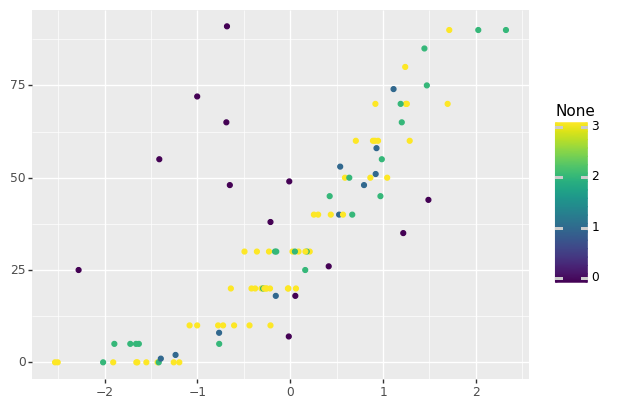

<ggplot: (8741913762841)>

In [8]:
sample_size = 100

x_norm = dist.Normal(0.,1.).sample(PRNGKey(0), (sample_size,))

# round_val = dist.Bernoulli(.25).sample(PRNGKey(1), (sample_size,))
round_policy = dist.Categorical(jnp.array([.1,.1,.25,.55])).sample(PRNGKey(1), (sample_size,))
round_val = np.where(round_policy <=1, 1, np.where(round_policy==2, 5, 10))

y = expit(-1 + 1.5*x_norm)
y = dist.Beta(y*50., (1-y)*50.).sample(PRNGKey(0))
y_rand = dist.Beta(1., 1.).sample(PRNGKey(0), (sample_size,))
y = jnp.where(round_policy==0, y_rand, y)

y_round_mix = round(y*100/round_val)*round_val


# y_round_full10 = round(y*100/10)*10

ggplot(aes(x=x_norm, y=y_round_mix, color=round_policy)) + geom_point()

In [47]:
round_policy

DeviceArray([3, 2, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 3, 3, 2, 2, 2, 3, 3, 3,
             2, 2, 3, 1, 3, 0, 3, 3, 1, 3, 0, 0, 2, 3, 3, 3, 3, 3, 1, 3,
             3, 2, 3, 3, 3, 3, 3, 2, 3, 0, 2, 2, 2, 0, 3, 1, 2, 0, 2, 3,
             1, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 3, 3, 0, 3, 2, 0, 2, 2, 3,
             1, 2, 3, 3, 3, 0, 0, 3, 3, 0, 2, 3, 0, 3, 3, 2, 2, 1, 3, 2],            dtype=int64)

In [76]:
def sum_probs(probs):
    # numerically stable summing of probabilities
    return jnp.exp(jax.scipy.special.logsumexp(jnp.log(probs)))

def log_sum_probs(probs):
    # numerically stable summing of probabilities
    return jax.scipy.special.logsumexp(jnp.log(probs))


    
def logdiff(l1, l2):
    return l1 + tfp.math.log1mexp(l2-l1)
    # return l1 + jnp.log1p(-jnp.exp(-(l1-l2)))


def subtract_probs(p1, p2):
    # numerically stable difference of probabilities
    return jnp.exp(logdiff(jnp.log(p1), jnp.log(p2)))


def spread_vec(x, step_size): # this works without static arguments
    base_steps = x.shape[0]
    x_split = jnp.split(x, base_steps)
    pad = jnp.zeros(step_size-1)
    probs = jnp.stack([jnp.concatenate((i,pad)) for i in x_split]).flatten()
    probs = probs[0:101]
    return probs/jnp.sum(probs)


def f3(mu, k, responses):
    
    a = mu*k
    b = (1.-mu)*k
    
    n_resps = (responses.shape[0]-1)
    step = int(100/n_resps)
    rnd_unit_scaled = 1/n_resps
    
    lower = jnp.clip((responses/n_resps) - rnd_unit_scaled/2., 1e-8, 1.-1e-8)
    upper = jnp.clip((responses/n_resps) + rnd_unit_scaled/2., 1e-8, 1.-1e-8)
    
    # prob_resps = subtract_probs(tfp.math.betainc(a, b, upper), tfp.math.betainc(a, b, lower))
    prob_resps = tfp.math.betainc(a, b, upper) - tfp.math.betainc(a, b, lower)
    prob_resps = spread_vec(prob_resps, step) + 1e-30
    # prob_resps = jnp.exp(jnp.log(prob_resps) - log_sum_probs(prob_resps)) # numerically better
    prob_resps = (prob_resps) / jnp.sum(prob_resps) # add err to prevent divergences
    
    return(prob_resps)


f3_multi = vmap(f3, (0, None, None))


def mymodel_round3(x, y=None):
    
    theta = numpyro.sample("theta", dist.Dirichlet(jnp.ones(3)))

    alpha = numpyro.sample("alpha", dist.Normal(0,1))
    beta = numpyro.sample("beta", dist.Normal(0,1))
    k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter
    
    mu = expit(alpha + beta*x)

#     resp_probs_raw = jnp.stack([f3_multi(mu, k, responses_1)*theta[1], f3_multi(mu, k, responses_5)*theta[1], f3_multi(mu, k, responses_10)*theta[1]])
#     theta_vec = jnp.broadcast_to(theta, (theta.shape[0], mu.shape[0]))
    
#     resp_probs = theta_vec*resp_probs_raw
    
    resp_probs = (
        1./101.*theta[0] +
        f3_multi(mu, k, responses_1)*theta[1] +
        f3_multi(mu, k, responses_5)*theta[2] + 
        f3_multi(mu, k, responses_10)*theta[3]
    )
    
    with numpyro.plate("data", x.shape[0]):

        yhat = numpyro.sample("yhat", dist.Categorical(probs=resp_probs), obs=y) # rounded

In [ ]:
kernel3 = NUTS(
    mymodel_round3, 
    target_accept_prob=.80#,
    # init_strategy = init_to_value(values = {"alpha":0., "beta":0., "k":5.})
)

mcmc3 = MCMC(kernel3, 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=1)

mcmc3.run(random.PRNGKey(0), x_norm, y_round_mix)

In [332]:
mcmc3.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -1.00      0.03     -1.00     -1.04     -0.95   1126.61      1.00
      beta      1.48      0.03      1.48      1.42      1.53   1042.88      1.00
         k     50.86      6.41     50.43     41.11     61.37   1054.73      1.00
  theta[0]      0.11      0.02      0.10      0.07      0.14   1304.54      1.00
  theta[1]      0.09      0.02      0.09      0.05      0.12   1271.95      1.00
  theta[2]      0.27      0.04      0.27      0.21      0.34   1219.38      1.00
  theta[3]      0.53      0.04      0.53      0.47      0.60   1357.72      1.00

Number of divergences: 0


### It works!

Got it working for mixture of two rounding policies: model correctly recovers all parameters.

And then got it working for mixture of 3 rounding policies plus a "contaminant" process! (though it took 36m for 2k samples)

Attempts to speed things up below

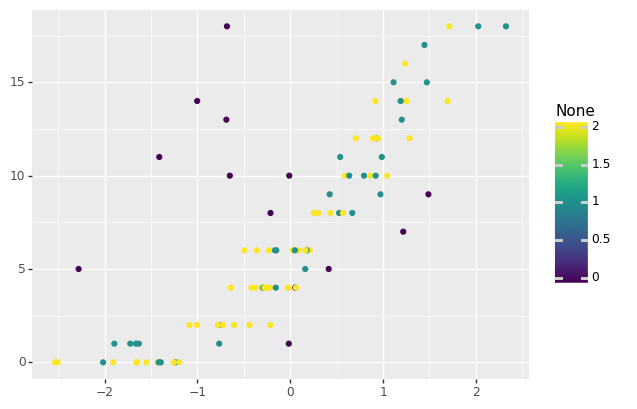

<ggplot: (8741810943064)>

In [100]:
sample_size = 100

x_norm = dist.Normal(0.,1.).sample(PRNGKey(0), (sample_size,))

# round_val = dist.Bernoulli(.25).sample(PRNGKey(1), (sample_size,))
round_policy = dist.Categorical(jnp.array([.1,.35,.55])).sample(PRNGKey(1), (sample_size,))
round_val = np.where(round_policy <=1, 5, 10)

y = expit(-1 + 1.5*x_norm)
y = dist.Beta(y*50., (1-y)*50.).sample(PRNGKey(0))
y_rand = dist.Beta(1., 1.).sample(PRNGKey(0), (sample_size,))
y = jnp.where(round_policy==0, y_rand, y)

y_round_mix = jnp.asarray(round(y*100/round_val)*round_val/5, dtype="int")

ggplot(aes(x=x_norm, y=y_round_mix, color=round_policy)) + geom_point()

In [101]:
y_round_mix

DeviceArray([ 0, 11,  4, 10,  4, 14, 10, 18,  0,  2,  4,  8,  0,  6,  1,
              6,  5,  2, 12,  4,  4,  8, 12, 11,  2,  5,  6,  8,  2, 10,
              1,  4, 18, 14,  0,  6,  6,  6, 10,  4,  2, 13,  0, 14,  0,
              6,  0,  9,  0,  5,  0,  6,  9, 14,  0,  8,  1, 11,  1, 16,
             12, 12,  2,  2, 15,  4,  1, 10, 17,  4,  4,  8,  8, 10,  4,
              6,  7,  0, 10,  0,  4,  6, 14, 12,  8,  9, 10,  4,  2, 13,
             14,  4, 18,  6,  4, 18, 15,  0, 12,  1], dtype=int64)

In [90]:
## rounding stuff
from jax import vmap

def expand_to_fullscale10(probs):
    # n_resps = probs.shape[0] # can't have sizes change based on arguments like this
    # repeats = jnp.asarray(100/(n_resps-1), dtype="int64")-1
    
    n_resps = 11 # probs.shape[0]
    repeats = 1 # 100/n_resps - 1
    
    res = jnp.insert(probs, jnp.repeat(jnp.arange(1, n_resps), repeats), 0) + 1e-30
    res = res/jnp.sum(res)
    
    return(res)



def f(mu, k, responses):
    
    a = mu*k
    b = (1.-mu)*k
    
    n_resps = (responses.shape[0]-1)
    step = int(100/n_resps)
    rnd_unit_scaled = 1/n_resps
    
    lower = jnp.clip((responses/n_resps) - rnd_unit_scaled/2., 1e-8, 1-1e-8)
    upper = jnp.clip((responses/n_resps) + rnd_unit_scaled/2., 1e-8, 1-1e-8)
    
    prob_resps = tfp.math.betainc(a, b, upper) - tfp.math.betainc(a, b, lower)
    
    return(prob_resps)


lbeta_cat_probs = vmap(f, (0, None, None))
spread_probs5 = vmap(expand_to_fullscale5)
# spread_probs10 = vmap(expand_to_fullscale10)

responses_10 = jnp.linspace(0, 10, num=11)
responses_5 = jnp.linspace(0, 20, num=21)
# responses_1 = jnp.linspace(0, 101, num=101)

In [94]:
def mymodel_round4(x, y=None):
    
    theta = numpyro.sample("theta", dist.Dirichlet(jnp.ones(3)))

    alpha = numpyro.sample("alpha", dist.Normal(0,1))
    beta = numpyro.sample("beta", dist.Normal(0,1))
    k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter
    
    mu = expit(alpha + beta*x)
    
    resp_probs = (
        1./21.*theta[0] +
        (lbeta_cat_probs(mu, k, responses_5) + 1e30)*theta[1] +
        # spread_probs5(lbeta_cat_probs(mu, k, responses_5)*theta[2]) + 
        spread_probs10(lbeta_cat_probs(mu, k, responses_10)*theta[2])
    )
    
    with numpyro.plate("data", x.shape[0]):

        yhat = numpyro.sample("yhat", dist.Categorical(probs=resp_probs), obs=y) # rounded

In [102]:
kernel4 = NUTS(
    mymodel_round4, 
    target_accept_prob=.80#,
    # init_strategy = init_to_value(values = {"alpha":0., "beta":0., "k":5.})
)

mcmc4 = MCMC(kernel4, 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=1)

mcmc4.run(random.PRNGKey(0), x_norm, y_round_mix)

warmup:  16%|█▋        | 325/2000 [01:35<08:10,  3.42it/s, 7 steps of size 6.98e-01. acc. prob=0.79] 


KeyboardInterrupt: 

In [316]:
import arviz as az

def make_arviz_data(mcmc, model, data):
    posterior_samples = mcmc.get_samples()

    posterior_predictive = Predictive(model, posterior_samples)(
        random.PRNGKey(1), data
    )
    prior = Predictive(model, num_samples=500)(
        random.PRNGKey(2), data
    )

    return az.from_numpyro(
        mcmc,
        prior = prior,
        posterior_predictive = posterior_predictive
    )

azdata = make_arviz_data(mcmc3, mymodel_round3, x_norm)

<AxesSubplot:xlabel='yhat / yhat'>

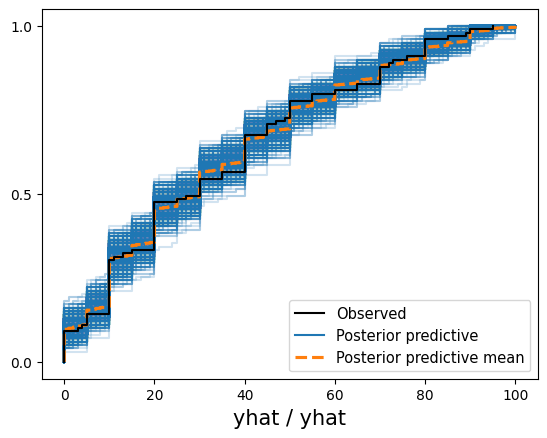

In [320]:
## arviz plots are kind of ugly for discrete data, have to do cumulative or it's wonky
az.plot_ppc(azdata,kind="cumulative")